# Optimierung und Evaluierung des Sequential bow Modells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import seaborn as sn
from wordcloud import WordCloud

from hyperopt import Trials, STATUS_OK, tpe

from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Activation
from keras.regularizers import l2, l1
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.models import load_model

from hyperas import optim
from hyperas.distributions import choice, uniform, normal, qlognormal, randint

from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


## Analyse des Inputs

In [2]:
x_test = pd.read_hdf("../build/preprocessed/bow_data.hdf5",key="test")
x_train = pd.read_hdf("../build/preprocessed/bow_data.hdf5",key="train")
X = x_test.append(x_train)

$$max\left(\frac{(\bar{w_1}-\bar{w_2})^2}{s_1^2+s_2^2}\right)$$

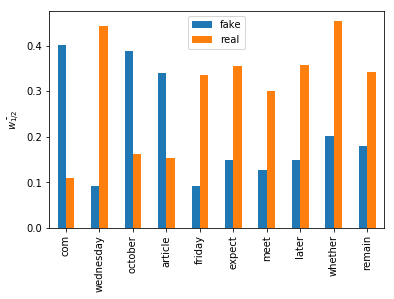

In [16]:
mu_real = X[X.label==1].mean()
mu_fake = X[X.label==0].mean()
sorted_words = ((mu_real-mu_fake)**2/(np.var(X[X.label==1])**2 + np.var([X.label==0])**2)).sort_values(ascending=False).index

words_plot = pd.DataFrame({'fake':X[X.label==0][sorted_words[1:11]].mean(),'real':X[X.label==1][sorted_words[1:11]].mean()})
words_plot.plot(kind='bar')
plt.ylabel(r"$\bar{w_{1/2}}$")
plt.legend()
plt.savefig("../build/plots/data_visualisation.pdf")
#plt.show()

## How could the Hyperparameter be distributed

### Strukture

Größe der ersten und zweiten hidden layer

In [ ]:
x = np.round(np.random.lognormal(6,0.5,10000)/10)*10
plt.hist(x,bins=100)
plt.xlim(0,5000)
plt.show()

Größer der dritten hidden layer

In [ ]:
x = np.round(np.random.lognormal(4,0.5,10000)/1)*1
plt.hist(x,bins=100)
plt.show()

### Regularization

In [ ]:
x =np.random.uniform(0,0.1,10000)
plt.hist(x,bins=100)
plt.show()

## Data preparation

In [ ]:
def data_bow():
    x_test = pd.read_hdf("../build/preprocessed/bow_data.hdf5",key="test")
    x_train = pd.read_hdf("../build/preprocessed/bow_data.hdf5",key="train")
    y_test = x_test.label
    y_train = x_train.label
    x_test= x_test.drop('label',axis=1)
    x_train = x_train.drop('label',axis=1)
    return x_train, y_train, x_test, y_test

## Model creation

In [ ]:
def model_structure(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(int({{qlognormal(6,0.5,10)}}), input_dim=dim))
    model.add(Activation('relu'))
    
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense(int({{qlognormal(6,0.5,10)}})))
        model.add(Activation('relu'))
        
    model.add(Dense(int({{qlognormal(4,0.5,1)}})))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer='adam')

    result = model.fit(x_train.values, y_train.values,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
def model_training(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(1770, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(9))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss={{choice(['hinge','binary_crossentropy','squared_hinge'])}}, metrics=['accuracy'],
                  optimizer={{choice(['adam','AdaDelta','Adagrad'])}})

    result = model.fit(x_train.values, y_train.values,
              batch_size=64,
              epochs=30,
              verbose=2,
              validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
def model_regularization(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense(1770, kernel_regularizer=l1({{uniform(0,0.1)}}), input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(9,kernel_regularizer=l2({{uniform(0,0.1)}})))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer='Adagrad')

    result = model.fit(x_train.values, y_train.values,
                      batch_size=64,
                      epochs=30,
                      verbose=2,
                      validation_split=0.3)
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

## Optimization with hyperopt
Algorithm: Tree of Parzen Estimators
Optimierung in 3 Schritten:
    - Struktur (Tiefe (2 oder 3 hidden Layers) und Breite)
    - Training (loss function und optimizer)
    - Regularizierung ( L1 für die erste Layer und L2 für 2 und 3)

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_structure,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=trials,
                                     notebook_name='Sequential_bow')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_struct_500.hdf5')

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_training,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=15,
                                      trials=trials,
                                     notebook_name='Sequential_bow')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_training_500.hdf5')

In [ ]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_regularization,
                                      data=data_bow,
                                      algo=tpe.suggest,
                                      max_evals=80,
                                      trials=trials,
                                     notebook_name='Sequential_bow')
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_bow_regularization_500.hdf5')

## Evaluation of best model

### Train best model
Neues Training des besten Modells, welches Optimiert bezüglich der Hyperparameter ist

In [ ]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    #plt.show()
    plt.savefig("../build/plots/bow/500/history_bow_best.pdf")
    plt.close()

In [ ]:
X_train, Y_train, X_test, Y_test = data_bow()
best_model = load_model('../model/best_Hyperopt_NN_bow_regularization_500.hdf5')
model = Sequential.from_config(best_model.get_config())
model.summary()

In [ ]:
filepath = '../model/best_Hyperopt_NN_bow_trained_500.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy',
              optimizer='Adagrad',
              metrics=['accuracy'])
history = model.fit(X_train.values, Y_train.values, validation_split=0.3,
                    epochs=100,batch_size=64, callbacks=[checkpoint])

In [ ]:
plot_history(history)

## Evaluation of best model
Betrachten des trainierten Modells. Darstellung der Confusion Matrix, Overtraining Plot und ROC Curve

In [ ]:
best_model = load_model('../model/best_Hyperopt_NN_bow_trained_500.hdf5')
y_pred = best_model.predict(X_test.values, batch_size=64, verbose=1)
y_pred_train = best_model.predict(X_train.values, batch_size=64, verbose=1)
y_pred_bool = np.round(y_pred[:,0])
Y_test = pd.DataFrame({"label":Y_test,"prediction":y_pred[:,0],"prediction_bool":y_pred_bool})
Y_train = pd.DataFrame({"label":Y_train,"prediction":y_pred_train[:,0]})

In [ ]:
print(classification_report(Y_test['label'], Y_test['prediction_bool']))

#Confusion Matrix
cnfn_matrix = pd.crosstab(Y_test['label'], Y_test['prediction_bool'], rownames=['Actual'], colnames=['Predicted'])
print(cnfn_matrix)
cnfn_matrix.columns = ['fake','real']
cnfn_matrix = cnfn_matrix.rename_axis("Predicted", axis="columns")
cnfn_matrix.rename(index = {0.0: "fake", 1.0:'real'}, inplace = True) 
cnfn_matrix = cnfn_matrix/Y_test.shape[0]
sn.heatmap(cnfn_matrix, annot=True , cmap='viridis')
#plt.show()
plt.savefig("../build/plots/bow/500/cnfsn_mtx_bow_best_nn.pdf")
plt.close()

#Overtraining test
plt.hist(Y_test.prediction[Y_test.label == 0],label="fake test", alpha = 0.4, color = "r",density=True)
plt.hist(Y_train.prediction[Y_train.label == 0],label='fake train', alpha = 0.4, color = 'r', histtype='step',density=True)
plt.hist(Y_test.prediction[Y_test.label == 1],label = "real test",alpha = 0.4, color = "b",density=True)
plt.hist(Y_train.prediction[Y_train.label == 1],label='real train', alpha = 0.4, color = 'b', histtype='step',density=True)

plt.xlabel("Prediction Probability")
plt.ylabel("density")
plt.legend(loc='upper center')
#plt.show()
plt.savefig("../build/plots/bow/500/prob_bow_best_nn.pdf")
plt.close()

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_test.label, Y_test.prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("../build/plots/bow/500/roc_Hyperopt_bow_best_nn.pdf")
plt.close()

## Interpretation

### Wordcloud confusion matrix

Darstellung der Wordhäufigkeiten in WordClouds für FP,FN,TP,TN getrennt

In [ ]:
FP = Y_test[(Y_test.prediction_bool== 1) & (Y_test.label == 0)]
FN = Y_test[(Y_test.prediction_bool== 0) & (Y_test.label == 1)]
TP = Y_test[(Y_test.prediction_bool== 1) & (Y_test.label == 1)]
TN = Y_test[(Y_test.prediction_bool== 0) & (Y_test.label == 0)]
X_FP = X_test.loc[FP.index]
X_FN = X_test.loc[FN.index]
X_TP = X_test.loc[TP.index]
X_TN = X_test.loc[TN.index]

In [ ]:
from wordcloud import WordCloud
from PIL import Image
from PIL import ImageFilter
def plotWordcloud_cnfn(TN,FN,FP,TP):    
    TN = TN.sum().to_dict()
    FN = FN.sum().to_dict()
    FP = FP.sum().to_dict()
    TP = TP.sum().to_dict()
    
    pad = 5
    
    fig = plt.figure(figsize=(15,10),dpi=100)

    ax = plt.subplot(2, 2, 1)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/trump_silhouette.png'))
                          ).generate_from_frequencies(TN)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    ax = plt.subplot(2, 2, 2)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask= np.array(Image.open('../data/pictures/trump_silhouette.png'))
                          ).generate_from_frequencies(FP)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    ax = plt.subplot(2, 2, 3)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/USA.jpg'))
                          ).generate_from_frequencies(FN)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

    plt.subplot(2, 2, 4)
    wordcloud = WordCloud(background_color='black',
                          width=1920,
                          height=1080,
                          mask=np.array(Image.open('../data/pictures/USA.jpg'))
                          ).generate_from_frequencies(TP)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    plt.figtext(0.5, 1.09, r"Prediction", {'fontsize': 30},
         horizontalalignment='center',
         verticalalignment='top')
    plt.figtext(0.25, 1.02, r"fake", {'fontsize': 20},
         horizontalalignment='center',
         verticalalignment='bottom',)
    plt.figtext(0.75, 1.02, r"real", {'fontsize': 20},
         horizontalalignment='center',
         verticalalignment='bottom',)
    
    plt.figtext(-0.07, 0.5, r"Actual", {'fontsize': 30},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=90)
    plt.figtext(0.00, 0.75, r"fake", {'fontsize': 20},
         horizontalalignment='right',
         verticalalignment='center',)
    plt.figtext(0.00, 0.25, r"real", {'fontsize': 20},
         horizontalalignment='right',
         verticalalignment='center',)
    
    plt.margins(x=0, y=0)
    plt.tight_layout()
    #plt.show()
    plt.savefig("../build/plots/bow/500/cnfn_wordcloud.pdf", bbox_inches = 'tight')
    plt.close()

In [ ]:
plotWordcloud_cnfn(X_TN,X_FN,X_FP,X_TP)

### Wordcloud fake real news

In [ ]:
def plotWordcloud(content,t):
    if(t!=""):
       mask = np.array(Image.open('../data/pictures/'+t))
    else:
        mask=None
        

    content = content.sum().to_dict()
    wordcloud = WordCloud(background_color='black',
                      width=1920,
                      height=1080,
                      mask=mask
                      ).generate_from_frequencies(content)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)

In [ ]:
X = X_test.append(X_train)
y = Y_test.append(Y_train)
plotWordcloud(X[y.label==0],"trump_silhouette.png")
plt.show()
#plt.savefig("../build/plots/fake_wordcloud.pdf")
plt.close()
plotWordcloud(X[y.label==1],"USA.jpg")
plt.show()
#plt.savefig("../build/plots/real_wordcloud.pdf")
plt.close()

## Untersuchung der first layer

Summieren der Beträge aller Gewichte eines Neurons ohne Offset und anschließende Darstellung in WordCloud

In [ ]:
words = X_test.columns
first_weights = best_model.layers[0].get_weights()[0]
first_weights = pd.DataFrame(first_weights.transpose())
first_weights.columns = words
first_weightabs = np.abs(first_weights)
first_weightsum = first_weightabs.sum(axis=0)
content = np.abs(first_weightsum).to_dict()
wordcloud = WordCloud(background_color='black',
                      width=1920,
                      height=1080
                      ).generate_from_frequencies(content)
plt.figure(dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
#plt.show()
plt.savefig("../build/plots/bow/500/weights_wordcloud.pdf")
plt.close()

Untersuchung der Confusion Matrix mithilfe der wichtigsten 10 Wörter 

In [ ]:
sorted_weights = first_weightsum.sort_values(ascending=False)
best_words = sorted_weights[:10].index

fig = plt.figure(figsize=(15,10),dpi=100)

ax = plt.subplot(2, 2, 1)
(X_TN[best_words].sum()/X_TN.shape[0]).plot(kind='bar',label="TN",color='r')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)

ax = plt.subplot(2, 2, 2)
(X_FP[best_words].sum()/X_FP.shape[0]).plot(kind='bar',label="FP",color='g')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)

ax = plt.subplot(2, 2, 3)
(X_FN[best_words].sum()/X_FN.shape[0]).plot(kind='bar',label="FN",color='k')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)

plt.subplot(2, 2, 4)
(X_TP[best_words].sum()/X_TP.shape[0]).plot(kind='bar',label="TP",color='b')
plt.margins(x=0, y=0)
plt.ylabel("mittlere Worthäufigkeit")
plt.ylim(0,1)
    
plt.figtext(0.5, 1.09, r"Prediction", {'fontsize': 30},
     horizontalalignment='center',
     verticalalignment='top')
plt.figtext(0.25, 1.02, r"fake", {'fontsize': 20},
     horizontalalignment='center',
     verticalalignment='bottom',)
plt.figtext(0.75, 1.02, r"real", {'fontsize': 20},
     horizontalalignment='center',
     verticalalignment='bottom',)
    
plt.figtext(-0.07, 0.5, r"Actual", {'fontsize': 30},
     horizontalalignment='left',
     verticalalignment='center',
     rotation=90)
plt.figtext(0.00, 0.75, r"fake", {'fontsize': 20},
     horizontalalignment='right',
     verticalalignment='center',)
plt.figtext(0.00, 0.25, r"real", {'fontsize': 20},
     horizontalalignment='right',
     verticalalignment='center',)
    
plt.margins(x=0, y=0)
plt.tight_layout()
#plt.show()
plt.savefig("../build/plots/bow/500/cnfn_hist.pdf", bbox_inches = 'tight')
plt.close()

### RF Vergleichsmodell
Training einer RF auf dem bow Input und Evaluierung

In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0,criterion='entropy')
RF.fit(X_train.values,Y_train.label.values)

In [ ]:
y_pred_bool_RF = RF.predict(X_test.values)
y_pred_RF = RF.predict_proba(X_test.values)
y_pred_RF = y_pred_RF[:,1]
y_pred_train_RF = RF.predict_proba(X_train.values)
y_pred_train_RF = y_pred_train_RF[:,1]
Y_test['prediction_RF'] = y_pred_RF
Y_test['prediction_bool_RF'] = y_pred_bool_RF
Y_train['prediction_RF'] = y_pred_train_RF

In [ ]:
print(classification_report(Y_test.label, Y_test.prediction_bool_RF))

#Confusion Matrix
cnfn_matrix = pd.crosstab(Y_test.label, Y_test.prediction_bool_RF, rownames=['Actual'], colnames=['Predicted'])
print(cnfn_matrix)
cnfn_matrix.columns = ['fake','real']
cnfn_matrix = cnfn_matrix.rename_axis("Predicted", axis="columns")
cnfn_matrix.rename(index = {0.0: "fake", 1.0:'real'}, inplace = True) 
cnfn_matrix = cnfn_matrix/Y_test.shape[0]
sn.heatmap(cnfn_matrix, annot=True , cmap='viridis')
#plt.show()
plt.savefig("../build/plots/bow/500/RF/cnfsn_mtx_bow_best_nn.pdf")
plt.close()

#Overtraining test
bin_edges = np.linspace(0,1,11)
plt.hist(Y_test.prediction_RF[Y_test.label == 0],label="fake test", alpha = 0.4, color = "r",density=True,bins=bin_edges)
plt.hist(Y_train.prediction_RF[Y_train.label == 0],label='fake train', alpha = 0.4, color = 'r', histtype='step',density=True,bins=bin_edges)
plt.hist(Y_test.prediction_RF[Y_test.label == 1],label = "real test",alpha = 0.4, color = "b",density=True,bins=bin_edges)
plt.hist(Y_train.prediction_RF[Y_train.label == 1],label='real train', alpha = 0.4, color = 'b', histtype='step',density=True,bins=bin_edges)

plt.xlabel("Prediction Probability")
plt.ylabel("density")
plt.legend(loc='upper center')
#plt.show()
plt.savefig("../build/plots/bow/500/RF/prob_bow_best_nn.pdf")
plt.close()

fpr_RF = dict()
tpr_RF = dict()
roc_auc_RF = dict()
fpr_RF, tpr_RF, _ = roc_curve(Y_test.label, Y_test.prediction_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.figure()
lw = 2
plt.plot(fpr_RF, tpr_RF, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("../build/plots/bow/500/RF/roc_Hyperopt_bow_best_nn.pdf")
plt.close()

### Comparison
Vergleich des Sequential mit dem RF in der ROC Curve

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Sequential (area = %0.2f)' % roc_auc)
plt.plot(fpr_RF, tpr_RF, color='darkred',
         lw=lw, label='RandomForest (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("../build/plots/bow/500/roc_comparison.pdf")
plt.close()